## Face Recognition by using Linear Discriminant Analysis

In [1]:
from matplotlib import pyplot as plt
from matplotlib.image import imread
from numpy.linalg import inv
import numpy as np
import os

In [2]:
dataset_path = 'dataset/'
dataset_dir  = os.listdir(dataset_path)

width  = 92
height = 112

Train Images:


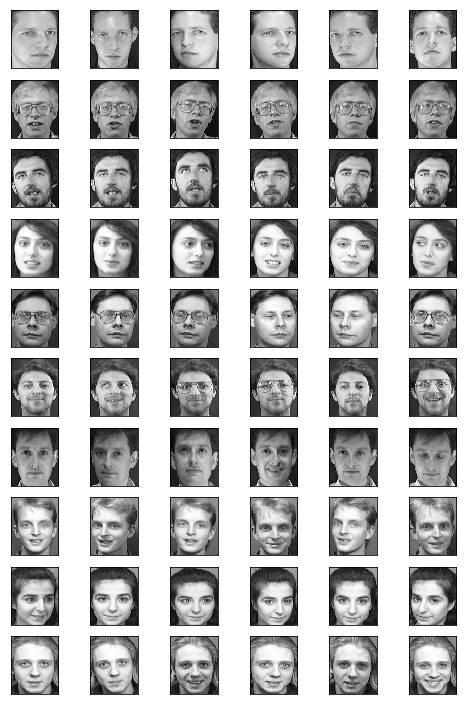

In [3]:
number_of_classes=10
img_in_class=6

print('Train Images:')

training_tensor   = np.ndarray(shape=(number_of_classes*img_in_class, height*width), dtype=np.float64)

for i in range(number_of_classes):
    for j in range(img_in_class):
        img = plt.imread(dataset_path + 'training1/s'+str(i+1)+'/'+str(j+1)+'.pgm')
        training_tensor[img_in_class*i+j,:] = np.array(img, dtype='float64').flatten()
        plt.subplot(number_of_classes,img_in_class,1+img_in_class*i+j)
        plt.imshow(img, cmap='gray')
        plt.subplots_adjust(right=1.2, top=2.5)
        plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
plt.show()

Test Images:


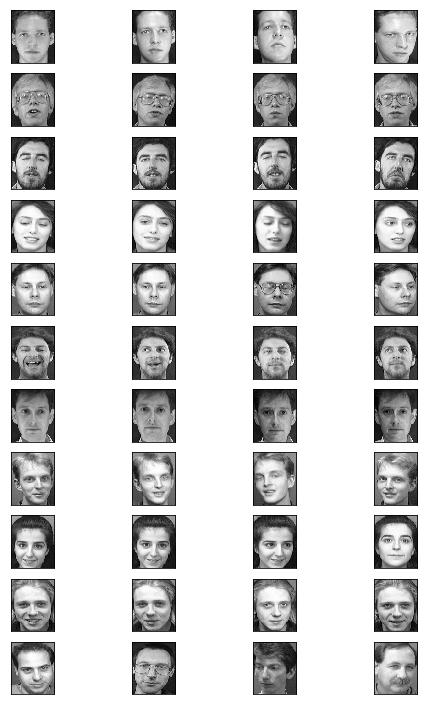

In [4]:
print('Test Images:')
testing_tensor   = np.ndarray(shape=(44, height*width), dtype=np.float64)

for i in range(44):
    img = imread(dataset_path + 'test/'+str(i+1)+'.pgm')
    testing_tensor[i,:] = np.array(img, dtype='float64').flatten()
    plt.subplot(11,4,1+i)
    plt.imshow(img, cmap='gray')
    plt.subplots_adjust(right=1.2, top=2.5)
    plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
plt.show()

## Apply PCA on the given data and make a database of projected faces

In [5]:
def PCA(training_tensor, number_chosen_components):
    
    mean_face = np.zeros((1,height*width))
    for i in training_tensor:
        mean_face = np.add(mean_face,i)
    mean_face = np.divide(mean_face,float(training_tensor.shape[0])).flatten()
    normalised_training_tensor = np.ndarray(shape=(training_tensor.shape))
    for i in range(training_tensor.shape[0]):
        normalised_training_tensor[i] = np.subtract(training_tensor[i],mean_face)        

    cov_matrix = np.cov(normalised_training_tensor)
    cov_matrix = np.divide(cov_matrix,float(training_tensor.shape[0]))
 
    eigenvalues, eigenvectors, = np.linalg.eig(cov_matrix)
    eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

    eig_pairs.sort(reverse=True)
    eigvalues_sort  = [eig_pairs[index][0] for index in range(len(eigenvalues))]
    eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]
    
    reduced_data = np.array(eigvectors_sort[:number_chosen_components]).transpose()

    proj_data = np.dot(training_tensor.transpose(),reduced_data)
    proj_data = proj_data.transpose()
    
    wx = np.array([np.dot(proj_data,img) for img in normalised_training_tensor])
    
    return proj_data, wx

In [6]:
number_chosen_components = 30
projected_data, projected_sig = PCA(training_tensor, number_chosen_components)
projected_sig.shape

(60, 30)

## Mean of each class and global mean

In [7]:
mew = np.zeros((number_of_classes, number_chosen_components))
M = np.zeros((1,number_chosen_components))

for i in range(number_of_classes):
    xa = projected_sig[img_in_class*i:img_in_class*i+img_in_class,:]
    for j in xa:
        mew[i,:] = np.add(mew[i,:],j)
    mew[i,:] = np.divide(mew[i,:],float(len(xa)))

for i in projected_sig:
    M = np.add(M,i)
M = np.divide(M,float(len(projected_sig)))

M.shape
mew.shape

(10, 30)

## Within class scatter matrix

In [8]:
normalised_wc_proj_sig = np.ndarray(shape=(number_of_classes*img_in_class, number_chosen_components), dtype=np.float64)

for i in range(number_of_classes):
    for j in range(img_in_class):
        normalised_wc_proj_sig[i*img_in_class+j,:] = np.subtract(projected_sig[i*img_in_class+j,:],mew[i,:])
normalised_wc_proj_sig.shape

sw = np.zeros((number_chosen_components,number_chosen_components))

for i in range(number_of_classes):
    xa = normalised_wc_proj_sig[img_in_class*i:img_in_class*i+img_in_class,:]
    xa = xa.transpose()
    cov = np.dot(xa,xa.T)
    sw = sw + cov
sw.shape

(30, 30)

## Between class scatter matrix


In [9]:
normalised_proj_sig = np.ndarray(shape=(number_of_classes*img_in_class, number_chosen_components), dtype=np.float64)
for i in range(number_of_classes*img_in_class):
    normalised_proj_sig[i,:] = np.subtract(projected_sig[i,:],M)

sb = np.dot(normalised_proj_sig.T,normalised_proj_sig)
sb = np.multiply(sb,float(img_in_class))
sb.shape

(30, 30)

## Use the criterion function


In [10]:
J = np.dot(inv(sw), sb)
J.shape

(30, 30)

## Eigenvalues and Eigenvectors

In [11]:
eigenvalues, eigenvectors, = np.linalg.eig(J)
print('Eigenvalues of Cov(X):',eigenvalues)
print('Eigenvectors of Cov(X):')
print(eigenvectors)

Eigenvalues of Cov(X): [2345.892462  +0.00000000e+00j  979.80881638+0.00000000e+00j
  489.97298908+0.00000000e+00j  509.2152726 +0.00000000e+00j
  295.98343842+0.00000000e+00j  230.13282131+0.00000000e+00j
   88.2242863 +0.00000000e+00j   95.72724993+0.00000000e+00j
   52.67472228+0.00000000e+00j    6.        +1.20823282e-13j
    6.        -1.20823282e-13j    6.        +4.54220991e-14j
    6.        -4.54220991e-14j    6.        +4.44311199e-14j
    6.        -4.44311199e-14j    6.        +0.00000000e+00j
    6.        +0.00000000e+00j    6.        +3.95588526e-14j
    6.        -3.95588526e-14j    6.        +0.00000000e+00j
    6.        +0.00000000e+00j    6.        +5.79021489e-15j
    6.        -5.79021489e-15j    6.        +1.87098110e-14j
    6.        -1.87098110e-14j    6.        +1.33448623e-14j
    6.        -1.33448623e-14j    6.        +0.00000000e+00j
    6.        +0.00000000e+00j    6.        +0.00000000e+00j]
Eigenvectors of Cov(X):
[[ 1.89401873e-01+0.00000000e+00j  2.

## Select the best principal components

In [12]:
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

eig_pairs.sort(key=lambda x: x[0],reverse=True)
eigvalues_sort  = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]

var_comp_sum = np.cumsum(eigvalues_sort)/sum(eigvalues_sort)

print("Cumulative proportion of variance explained vector:", var_comp_sum)

Cumulative proportion of variance explained vector: [0.44995359+0.00000000e+00j 0.63788569+0.00000000e+00j
 0.73555566+0.00000000e+00j 0.82953486+0.00000000e+00j
 0.88630592+0.00000000e+00j 0.93044652+0.00000000e+00j
 0.94880747+0.00000000e+00j 0.96572932+0.00000000e+00j
 0.97583259+0.00000000e+00j 0.97698342+8.71217965e-18j
 0.97813425+0.00000000e+00j 0.97928507+0.00000000e+00j
 0.9804359 +7.58758044e-18j 0.98158673+0.00000000e+00j
 0.98273756+1.11059139e-18j 0.98388839+0.00000000e+00j
 0.98503922+0.00000000e+00j 0.98619005+3.58863279e-18j
 0.98734088+0.00000000e+00j 0.98849171+0.00000000e+00j
 0.98964254+2.55960953e-18j 0.99079337+0.00000000e+00j
 0.9919442 +0.00000000e+00j 0.99309502+0.00000000e+00j
 0.99424585+0.00000000e+00j 0.99539668+2.31744935e-17j
 0.99654751+0.00000000e+00j 0.99769834+8.52210501e-18j
 0.99884917+0.00000000e+00j 1.        +0.00000000e+00j]


/home/shrikant/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


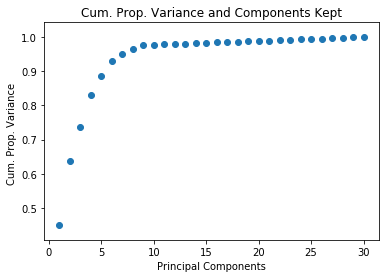

In [13]:
num_comp = range(1,len(eigvalues_sort)+1)
plt.title('Cum. Prop. Variance and Components Kept')
plt.xlabel('Principal Components')
plt.ylabel('Cum. Prop. Variance ')

plt.scatter(num_comp, var_comp_sum)
plt.show()

In [14]:
print('Number of eigen vectors:',len(eigvalues_sort))

number_chosen_components = 15
print("k:",number_chosen_components)
reduced_data = np.array(eigvectors_sort[:number_chosen_components]).transpose()
reduced_data.shape

Number of eigen vectors: 30
k: 15


(30, 15)

## Generate the fisher faces

In [15]:
projected_sig.shape
FP = np.dot(projected_sig, reduced_data)
FP.shape

(60, 15)

In [16]:
proj_data1 = np.dot(training_tensor.transpose(),FP)
proj_data1 = proj_data1.transpose()
proj_data1.shape

(15, 10304)

## Mean face

In [17]:
mean_face = np.zeros((1,height*width))

for i in training_tensor:
    mean_face = np.add(mean_face,i)

mean_face = np.divide(mean_face,float(len(training_tensor))).flatten()

## Testing

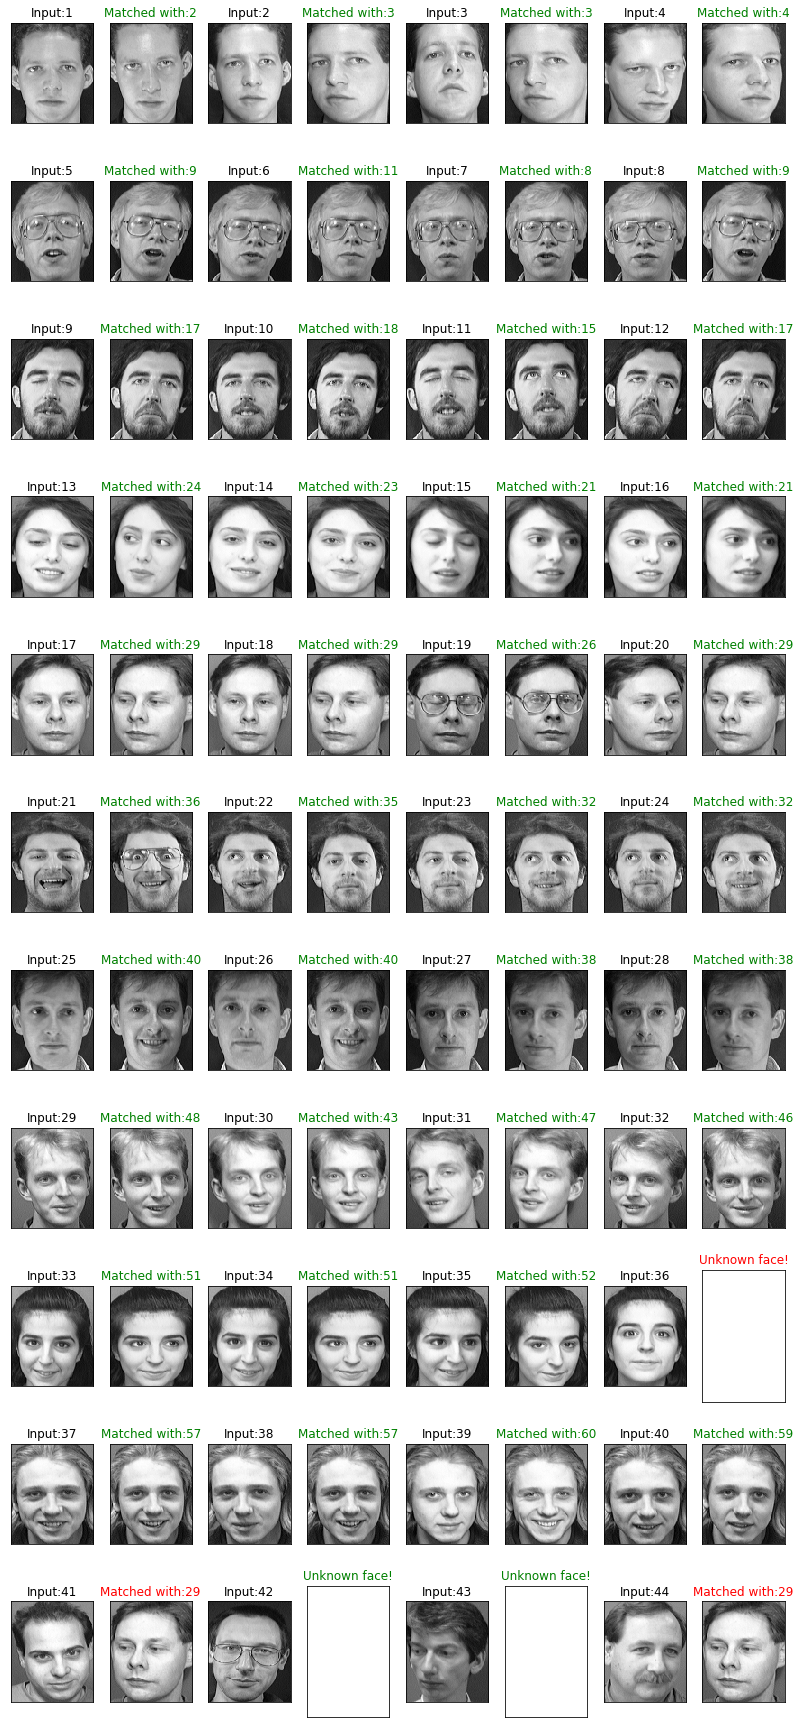

Correct predictions: 41/44 = 93.18181818181817%


In [18]:
count=0
num_images=0
correct_pred=0
def recogniser(img_number):
    global count,highest_min,num_images,correct_pred
    
    num_images          += 1
    unknown_face_vector = testing_tensor[img_number,:]
    normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)
    
    plt.subplot(11,8,1+count)
    plt.imshow(unknown_face_vector.reshape(height,width), cmap='gray')
    plt.title('Input:'+str(img_number+1))
    plt.subplots_adjust(right=1.2, top=2.5)
    plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
    count+=1
    
    PEF = np.dot(projected_data,normalised_uface_vector)
    proj_fisher_test_img = np.dot(reduced_data.T,PEF)
    diff  = FP - proj_fisher_test_img
    norms = np.linalg.norm(diff, axis=1)
    index = np.argmin(norms)
    
    plt.subplot(11,8,1+count)
    
    set_number = int(img_number/4)

    t0 = 7000000
       
    if norms[index] < t0:
        if(index>=(6*set_number) and index<(6*(set_number+1))):
            plt.title('Matched with:'+str(index+1), color='g')
            plt.imshow(training_tensor[index,:].reshape(height,width), cmap='gray')
            correct_pred += 1
        else:
            plt.title('Matched with:'+str(index+1), color='r')
            plt.imshow(training_tensor[index,:].reshape(height,width), cmap='gray')
    else:
        if(img_number>=40):
            plt.title('Unknown face!', color='g')
            correct_pred += 1
        else:
            plt.title('Unknown face!', color='r')
    plt.subplots_adjust(right=1.2, top=2.5)
    plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
    count+=1

fig = plt.figure(figsize=(10, 10))
for i in range(len(testing_tensor)):
    recogniser(i)

plt.show()

print('Correct predictions: {}/{} = {}%'.format(correct_pred, num_images, correct_pred/num_images*100.00))